In [1]:
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

## Data

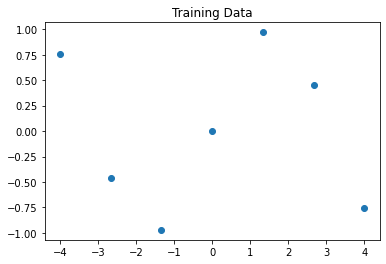

In [2]:
def data(num_points, test_points, key_, noise):

  X =  jnp.linspace(-4, 4, num_points).reshape(-1,1) 
  y = jnp.sin(X)

  test_points = 100
  X_test =  jnp.linspace(-5, 5, test_points).reshape(-1,1) 
  y_test = jnp.sin(X_test)

  if (noise):
    y = y + jax.random.normal(key = key_, shape = (num_points, 1)) * noise**0.5
    y_test = y_test + jax.random.normal(key = key_, shape = (test_points, 1)) * noise**0.5

  return X, y , X_test, y_test

# Visulaizing the train data
X, y, X_test, y_test = data(7, 100, key, noise = 0)
plt.scatter(X,y)
plt.title("Training Data")
plt.show()

## Sampling from Prior

In [3]:
def prior_samples(X_test, key, test_points):

  def rbf(x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

  Kstar_star = rbf(X_test, X_test.T, 0.1, 1)

  # prior mean equal to zero
  f_prior = jnp.dot(Kstar_star, jax.random.normal(key = key, shape = (test_points,10)))

  return f_prior

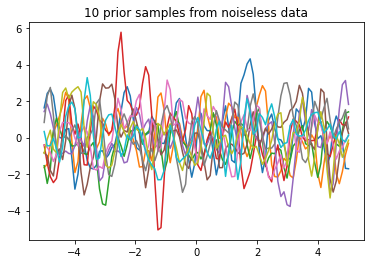

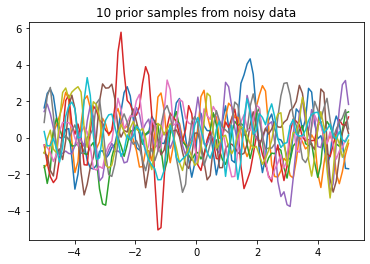

In [4]:
## Noiseless Data
X, y, X_test, y_test = data(7, 100, key, noise = 0)
f_prior = prior_samples(X_test, key, 100)
fig = plt.figure()
plt.plot(X_test, f_prior)
plt.title("10 prior samples from noiseless data")
plt.savefig('prior_sample_noiseless.png')

## Noisy Data
X, y, X_test, y_test = data(7, 100, key, noise = 0.4)
f_prior = prior_samples(X_test, key, 100)
fig = plt.figure()
plt.plot(X_test, f_prior)
plt.title("10 prior samples from noisy data")
plt.savefig('prior_sample_noise.png')

## GP Regression

In [15]:
class GP_Regression:
  
  def __init__(self, len_scale, sigmaf, kernel):
    self.len_scale = len_scale
    self.sigmaf = sigmaf
    self.kernel = kernel

  def rbf(self, x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
  
  def periodic_kernel(self, x, xstar, len_scale, sigmaf, period):
    return (sigmaf**2)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))


  def posterior(self, X, y, X_test, mu_prior, sigmay):
    # if (self.kernel == "rbf"):
    #   kernel_func = self.rbf
    # if(self.kernel == "perioidc"):
    #   kernel_func = self.periodic_kernel

    k = self.periodic_kernel(X,X.T,self.len_scale, self.sigmaf, 1.2)
    k = k + (sigmay * jnp.eye(len(X)))
    L = jnp.linalg.cholesky(k)
    kstar = self.periodic_kernel(X, X_test.T, self.len_scale, self.sigmaf, 1.2)
    kstar_star = self.periodic_kernel(X_test, X_test.T, self.len_scale, self.sigmaf, 1.2)

    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)

    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)

    return self.mu_posterior, self.cov_posterior

  def posterior_samples(self, key, test_points, samples):
    # prior mean equal to zero
    f_post = self.mu_posterior.reshape(-1,1) + jnp.dot(self.cov_posterior, jax.random.normal(key = key, shape = (test_points, samples)))

    return f_post

## Noiseless GP

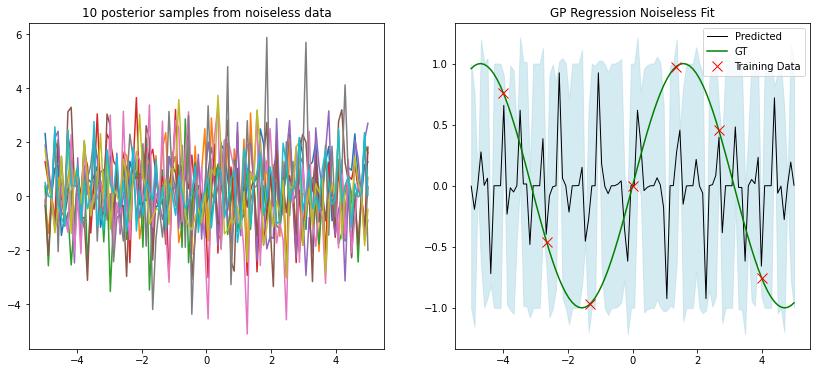

In [16]:
X, y, X_test, y_test = data(7, 100, key, noise = 0)
GPR_noiseless = GP_Regression(0.1, 1)
mu_posterior, cov_posterior = GPR_noiseless.posterior(X, y, X_test, 0, 0)

fig, ax = plt.subplots(1,2,figsize=(14,6))

# 10 posterior samples
f_post = GPR_noiseless.posterior_samples(key, 100, 10)
ax[0].plot(X_test, f_post)
ax[0].set_title("10 posterior samples from noiseless data")

# plot showing mean and covaraince of 
ax[1].plot(X_test, mu_posterior,'k',label='Predicted',lw=1)
ax[1].plot(X_test, y_test, 'g',label='GT',lw=1.5)
ax[1].plot(X, y, 'x', c = 'r', markersize=10, label='Training Data')

ax[1].fill_between(X_test.flatten(), 
                 (mu_posterior.flatten() - cov_posterior.diagonal().flatten()),
                 (mu_posterior.flatten() + cov_posterior.diagonal().flatten()),
                  color='lightblue', alpha=0.5)

plt.legend()
ax[1].set_title("GP Regression Noiseless Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()

## Noisy GP

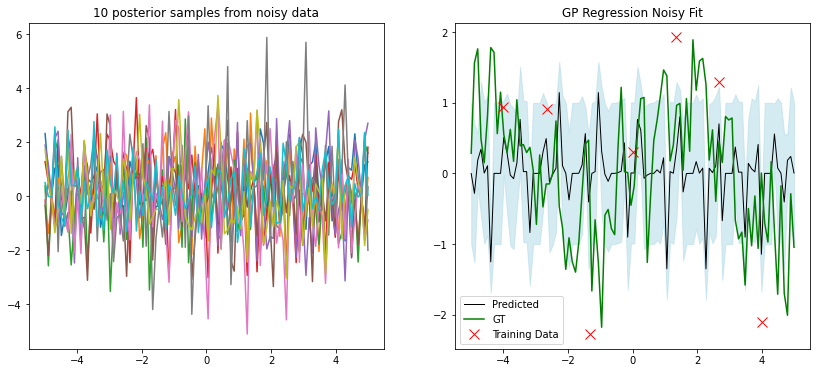

In [17]:
noise_variance = 0.6
X, y, X_test, y_test = data(7, 100, key, noise = noise_variance)
GPR_noise = GP_Regression(0.1, 1)
mu_posterior_noisy, cov_posterior_noisy = GPR_noise.posterior(X, y, X_test, 0, noise_variance)

fig, ax = plt.subplots(1,2,figsize=(14,6))

# 10 posterior samples
f_post = GPR_noiseless.posterior_samples(key, 100, 10)
ax[0].plot(X_test, f_post)
ax[0].set_title("10 posterior samples from noisy data")

# plot showing mean and covaraince of 
ax[1].plot(X_test, mu_posterior_noisy,'k',label='Predicted',lw=1)
ax[1].plot(X_test, y_test, 'g',label='GT',lw=1.5)
ax[1].plot(X, y, 'x', c = 'r', markersize=10, label='Training Data')

ax[1].fill_between(X_test.flatten(), 
                 (mu_posterior_noisy.flatten() - cov_posterior_noisy.diagonal().flatten()),
                 (mu_posterior_noisy.flatten() + cov_posterior_noisy.diagonal().flatten()),
                 color='lightblue', alpha=0.5)
plt.legend()
ax[1].set_title("GP Regression Noisy Fit")
# plt.savefig("GP_noisy_posterior.png")
plt.show()